In [164]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
plt.style.use('fivethirtyeight')
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,roc_curve,precision_score,recall_score

In [2]:
data1 = pd.read_csv("./data/Part2 - Data1.csv")
print(data1.shape)

data2  = pd.read_csv("./data/Part2 -Data2.csv")
print(data2.shape)

(5000, 8)
(5000, 7)


In [3]:
df = pd.merge(data1,data2,on="ID",how="inner")
print(df.shape)
df.head()

(5000, 14)


,ID,Age,CustomerSince,HighestSpend,ZipCode,HiddenScore,MonthlyAverageSpend,Level,Mortgage,Security,FixedDepositAccount,InternetBanking,CreditCard,LoanOnCard
0,1,25,1,49,91107,4,1.6,1,0,1,0,0,0,NaN
1,2,45,19,34,90089,3,1.5,1,0,1,0,0,0,NaN
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,NaN
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,NaN
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,1,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   5000 non-null   int64  
 1   Age                  5000 non-null   int64  
 2   CustomerSince        5000 non-null   int64  
 3   HighestSpend         5000 non-null   int64  
 4   ZipCode              5000 non-null   int64  
 5   HiddenScore          5000 non-null   int64  
 6   MonthlyAverageSpend  5000 non-null   float64
 7   Level                5000 non-null   int64  
 8   Mortgage             5000 non-null   int64  
 9   Security             5000 non-null   int64  
 10  FixedDepositAccount  5000 non-null   int64  
 11  InternetBanking      5000 non-null   int64  
 12  CreditCard           5000 non-null   int64  
 13  LoanOnCard           4980 non-null   float64
dtypes: float64(2), int64(12)
memory usage: 547.0 KB


In [5]:
df.isnull().sum()

ID                      0
Age                     0
CustomerSince           0
HighestSpend            0
ZipCode                 0
HiddenScore             0
MonthlyAverageSpend     0
Level                   0
Mortgage                0
Security                0
FixedDepositAccount     0
InternetBanking         0
CreditCard              0
LoanOnCard             20
dtype: int64

In [6]:
df.dropna(inplace=True)
df.reset_index(inplace=True,drop=True)
print(df.shape)

(4980, 14)


In [7]:
## Checking duplicates
df.ID.value_counts()[df.ID.value_counts() != 1]

Series([], Name: count, dtype: int64)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,4980.0,2510.345382,1438.011129,10.0,1265.75,2510.5,3755.250,5000.0
Age,4980.0,45.352610,11.464212,23.0,35.00,45.0,55.000,67.0
CustomerSince,4980.0,20.117671,11.468716,-3.0,10.00,20.0,30.000,43.0
HighestSpend,4980.0,73.852410,46.070090,8.0,39.00,64.0,98.000,224.0
ZipCode,4980.0,93152.420482,2123.660073,9307.0,91911.00,93407.0,94608.000,96651.0
HiddenScore,4980.0,2.395582,1.147200,1.0,1.00,2.0,3.000,4.0
MonthlyAverageSpend,4980.0,1.939536,1.750006,0.0,0.70,1.5,2.525,10.0
Level,4980.0,1.880924,0.840144,1.0,1.00,2.0,3.000,3.0
Mortgage,4980.0,56.589759,101.836758,0.0,0.00,0.0,101.000,635.0
Security,4980.0,0.104418,0.305832,0.0,0.00,0.0,0.000,1.0


In [9]:
df['CustomerSince'] = np.where((df["CustomerSince"] < 0),0,df['CustomerSince'])

In [10]:
all_cols = df.columns.tolist()
continuous_cols = ["CustomerSince","HighestSpend","Mortgage","MonthlyAverageSpend"]
discrete_cols = [col for col in all_cols if (col not in continuous_cols)]
discrete_cols.remove("ID")
discrete_cols.remove("ZipCode")


In [11]:
print(f"There are {df.ZipCode.nunique()} unique zipcodes of different customers")

There are 467 unique zipcodes of different customers


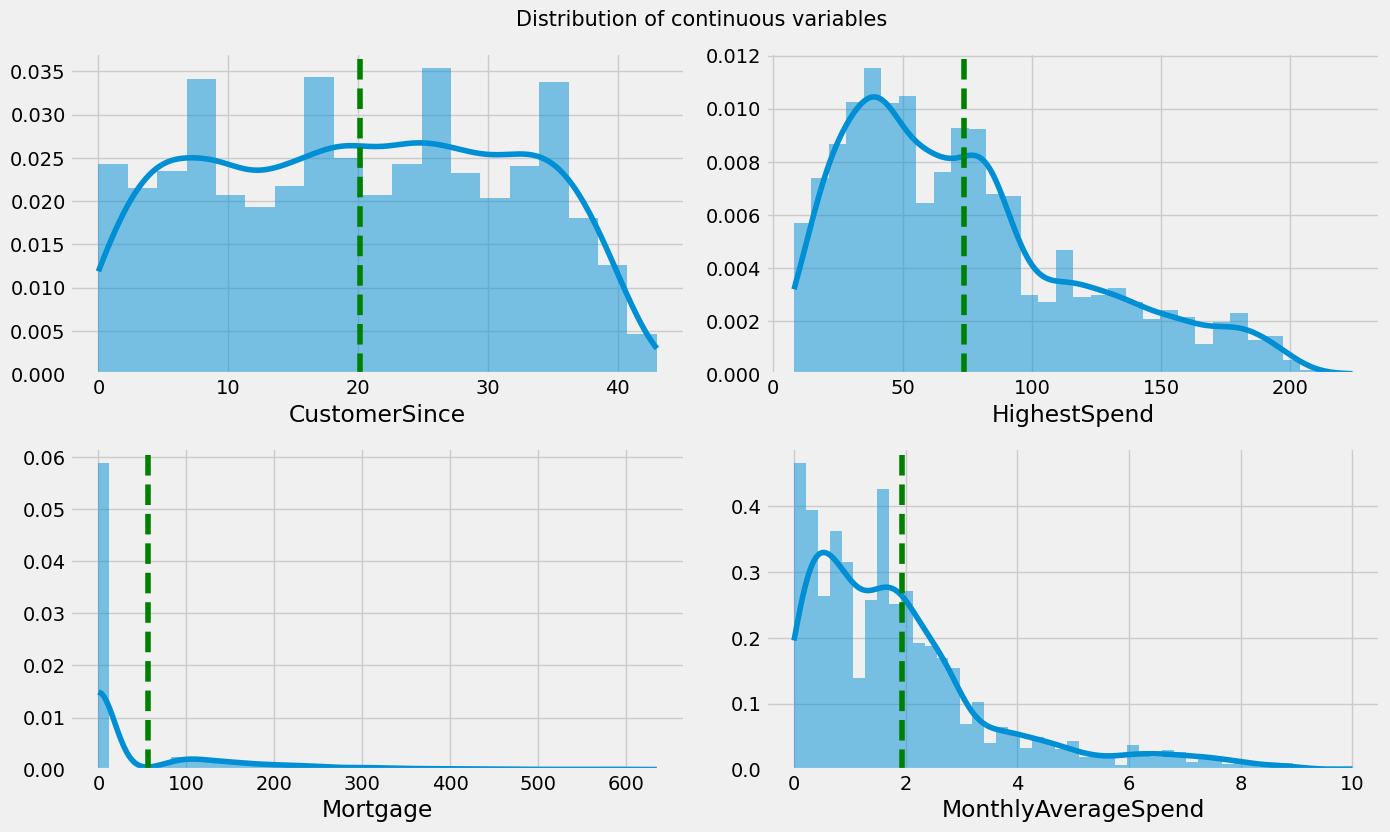

In [12]:
plt.figure(figsize=(14,12))
plt.suptitle("Distribution of continuous variables",fontsize=15)
for idx,col in enumerate(continuous_cols):
    ax =plt.subplot(3,2,idx+1)
    sns.histplot(x=col,linewidth=0,kde=True,stat='density',data=df,ax=ax)
    ax.axvline(df[col].mean(),linestyle="--",color="g")
    ax.set_ylabel(None)
    
plt.tight_layout()

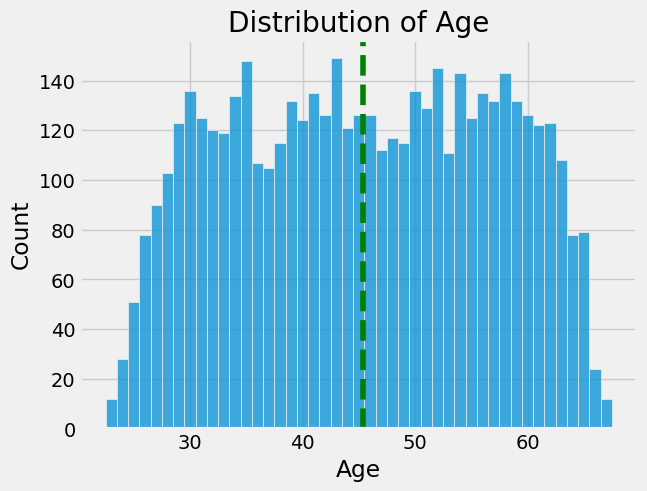

In [13]:
sns.histplot(x="Age",discrete=True,data=df)
plt.axvline(df["Age"].mean(),linestyle="--",color="g")
plt.title("Distribution of Age")
plt.show()

In [14]:
discrete_cols.remove("Age")
for col in discrete_cols:
    print(df[col].value_counts(normalize=True),"\n")

HiddenScore
1    0.294378
2    0.259639
4    0.243976
3    0.202008
Name: proportion, dtype: float64 

Level
1    0.419478
3    0.300402
2    0.280120
Name: proportion, dtype: float64 

Security
0    0.895582
1    0.104418
Name: proportion, dtype: float64 

FixedDepositAccount
0    0.939357
1    0.060643
Name: proportion, dtype: float64 

InternetBanking
1    0.597189
0    0.402811
Name: proportion, dtype: float64 

CreditCard
0    0.705622
1    0.294378
Name: proportion, dtype: float64 

LoanOnCard
0.0    0.903614
1.0    0.096386
Name: proportion, dtype: float64 



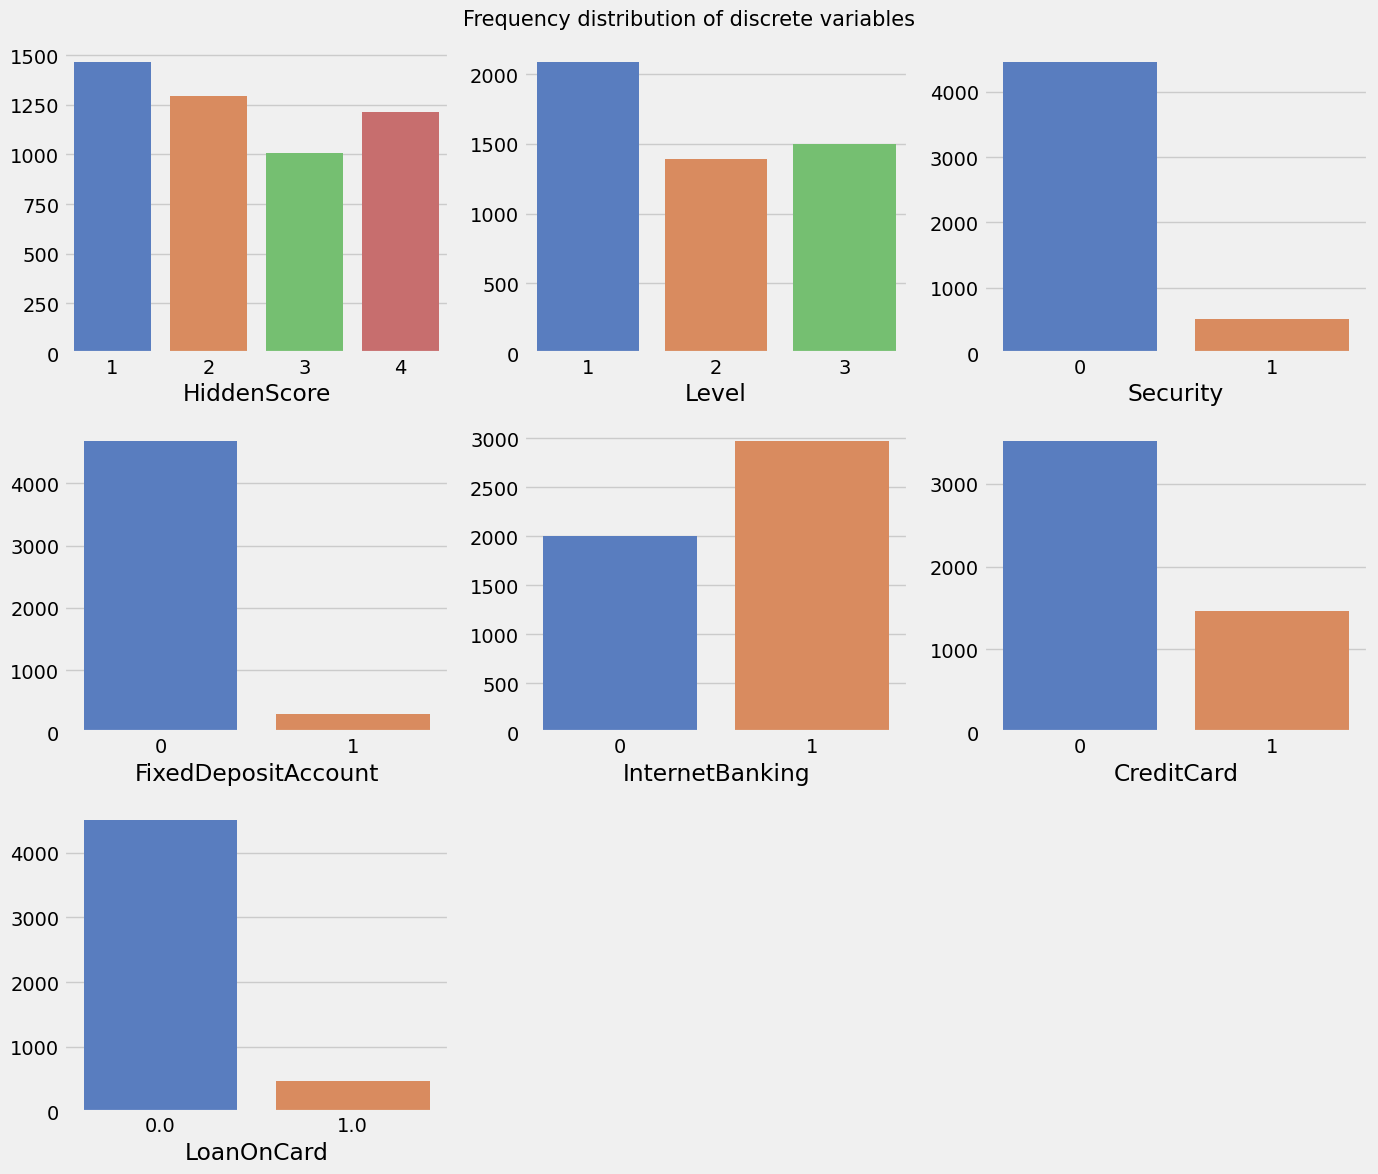

In [15]:
plt.figure(figsize=(14,12))
plt.suptitle("Frequency distribution of discrete variables",fontsize=15)
for idx,col in enumerate(discrete_cols):
    ax =plt.subplot(3,3,idx+1)
    sns.countplot(x = col, hue=col,palette='muted',data=df,ax=ax,legend=False)
    ax.set_ylabel(None)
    
plt.tight_layout()

We can see that in our target variable (LoanOnCard) the classes are imbalanced

In [40]:
df.groupby("Age")['MonthlyAverageSpend'].agg(['sum']).nlargest(5,"sum")

,sum
Age,
43,314.07
35,310.43
46,302.02
34,292.52
45,292.10


* The above Age group (34-46) have the highest monthly average spend
* Bank can target this group to sell their credit cards

In [16]:
print(df[df["CreditCard"] ==1].groupby(["Age","CreditCard"])['MonthlyAverageSpend'].agg(['sum']).nlargest(5,"sum"))

print(df[df["CreditCard"] ==0].groupby(["Age","CreditCard"])['MonthlyAverageSpend'].agg(['sum']).nlargest(5,"sum"))

                   sum
Age CreditCard        
46  1           137.64
45  1           104.57
32  1            87.60
58  1            87.60
36  1            87.54
                   sum
Age CreditCard        
35  0           244.53
43  0           236.72
52  0           216.80
34  0           215.36
30  0           200.51


Customers in the age group 30 to 43 spend more each month those who are not owning a credit card

In [42]:
df.groupby("Age")['HighestSpend'].agg(['mean']).nlargest(5,"mean")

,mean
Age,
65,84.278481
26,84.051282
46,82.714286
37,81.742857
45,81.492063


The above age group have the highest amount during one transaction

In [43]:
df.groupby("Age")['FixedDepositAccount'].agg(['sum']).nlargest(5,"sum")

,sum
Age,
32,16
56,14
46,13
42,12
57,12


Customers during their 30's invest more on FD's

CreditCard
0    6841.65
1    2817.24
Name: MonthlyAverageSpend, dtype: float64


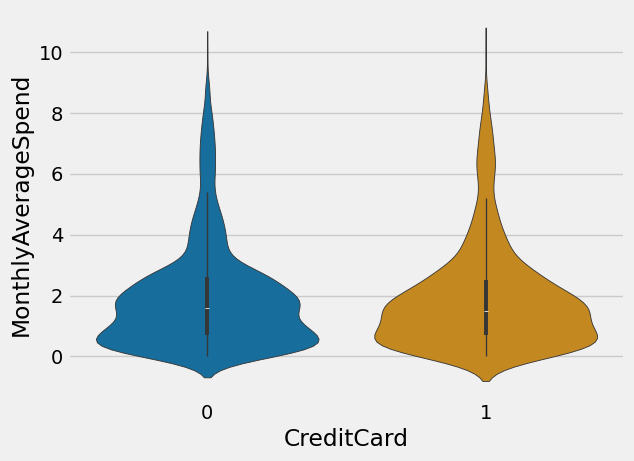

In [97]:
print(df.groupby(['CreditCard'])['MonthlyAverageSpend'].sum())
sns.violinplot(data=df,x="CreditCard",y="MonthlyAverageSpend",hue="CreditCard",palette='colorblind',legend=False);

Customers who dont own a credit card have highest monthly Average Spend

CreditCard
0    259808
1    107977
Name: HighestSpend, dtype: int64


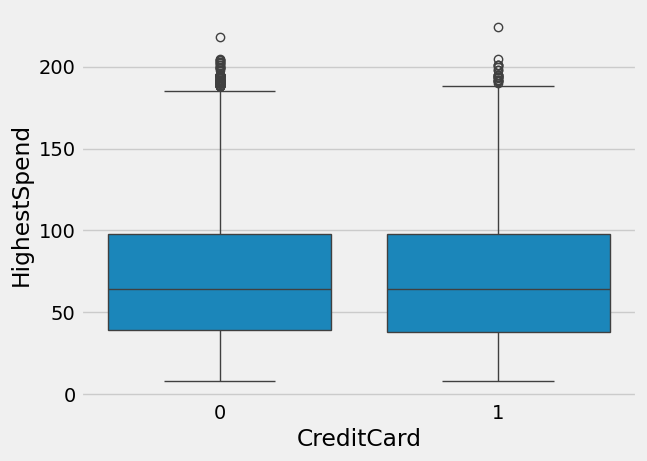

In [98]:
print(df.groupby(['CreditCard'])['HighestSpend'].sum())
sns.boxplot(data=df,x="CreditCard",y="HighestSpend");

Customers who do not have a credit card have less amount spent in one transaction

In [99]:
print(df.groupby(['FixedDepositAccount'])['MonthlyAverageSpend'].sum())

FixedDepositAccount
0    8789.44
1     869.45
Name: MonthlyAverageSpend, dtype: float64


Customers having a FD account tend to spend less amount in each month

In [115]:
df.groupby(['Age']).agg({"LoanOnCard":'count'}).nlargest(5,'LoanOnCard')

,LoanOnCard
Age,
43,149
35,148
52,145
54,143
58,143


The above Age group are the customers who are likely to accept the loan with Credit Card

In [101]:
df.LoanOnCard.value_counts(normalize=True)

LoanOnCard
0.0    0.903614
1.0    0.096386
Name: proportion, dtype: float64

Class distribution is imbalanced

In [33]:
df[["LoanOnCard","FixedDepositAccount"]].value_counts()

LoanOnCard  FixedDepositAccount
0.0         0                      4338
1.0         0                       340
0.0         1                       162
1.0         1                       140
Name: count, dtype: int64

People who have accepted the loan generally do not have FD account with the bank

In [17]:
df.groupby(["CreditCard"])["MonthlyAverageSpend"].sum()

CreditCard
0    6841.65
1    2817.24
Name: MonthlyAverageSpend, dtype: float64

Customers who possess credit card spend less amount each month 

In [22]:
df.groupby(["LoanOnCard","Security"]).agg({"Security":'count'})

Security
LoanOnCard Security          
0.0        0             4040
           1              460
1.0        0              420
           1               60

Not all customers have given their securty asset to bank while taking loan



In [52]:
df.groupby(['LoanOnCard'])['InternetBanking'].sum()

LoanOnCard
0.0    2683
1.0     291
Name: InternetBanking, dtype: int64

Very less customers who have accepted the loan use internet Banking

In [28]:
df[["CreditCard","LoanOnCard"]].value_counts()

CreditCard  LoanOnCard
0           0.0           3177
1           0.0           1323
0           1.0            337
1           1.0            143
Name: count, dtype: int64

Non credit card holders are the potential customers for loan

# ML model training

In [35]:
predictors = df.drop(columns=['ID',"ZipCode","LoanOnCard"],axis=1)
target = df.loc[:,'LoanOnCard']

In [36]:
## Splitting the data into training and testing
X_train,X_test,y_train,y_test = train_test_split(predictors,target,test_size=0.3,random_state=44)

In [37]:
##Scaling
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test  = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)
X_train.head(3)


,Age,CustomerSince,HighestSpend,HiddenScore,MonthlyAverageSpend,Level,Mortgage,Security,FixedDepositAccount,InternetBanking,CreditCard
0,0.000000,0.000000,0.671429,0.000000,0.633,0.0,0.494327,0.0,0.0,0.0,1.0
1,0.772727,0.720930,0.223810,0.666667,0.250,0.0,0.354943,0.0,1.0,1.0,1.0
2,0.227273,0.186047,0.809524,0.666667,0.850,0.0,0.000000,1.0,1.0,1.0,0.0


In [38]:
## Logistic regression

lgb = LogisticRegression(random_state=100).fit(X_train,y_train)

lgb_pred = lgb.predict(X_test)
lgb_pred_prob = lgb.predict_proba(X_test)[:,1]

train_acc= accuracy_score(y_train,lgb.predict(X_train))
test_acc = accuracy_score(y_test,lgb_pred)

print("Training accuracy :",train_acc)
print("\nTesting accuracy :",test_acc)


print("\nConfusion Matrix :\n",confusion_matrix(y_test,lgb_pred))
print("\n",classification_report(y_test,lgb_pred))

fpr_lgb,tpr_lgb,thresholds_lgb = roc_curve(y_test,lgb_pred_prob)
auc_score_lgb = roc_auc_score(y_test,lgb_pred_prob)
print("AUC score :",auc_score_lgb)

Training accuracy : 0.9492254733218589

Testing accuracy : 0.9605087014725568

Confusion Matrix :
 [[1354   11]
 [  48   81]]

               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1365
         1.0       0.88      0.63      0.73       129

    accuracy                           0.96      1494
   macro avg       0.92      0.81      0.86      1494
weighted avg       0.96      0.96      0.96      1494

AUC score : 0.9541812192974983


In [53]:
print(cross_val_score(lgb,X_train,y_train,cv=10,n_jobs=-1,scoring="precision"))

[0.92       0.95238095 0.89285714 0.78947368 0.90909091 0.84
 0.88235294 0.69230769 0.79310345 0.91304348]


In [39]:
##Naive Bayes
nb = MultinomialNB().fit(X_train,y_train)

nb_pred = nb.predict(X_test)
nb_pred_prob = nb.predict_proba(X_test)[:,1]

train_acc_nb= accuracy_score(y_train,nb.predict(X_train))
test_acc_nb = accuracy_score(y_test,nb_pred)

print("Training accuracy :",train_acc_nb)
print("\nTesting accuracy :",test_acc_nb)

print("\nConfusion Matrix :\n",confusion_matrix(y_test,nb_pred))
print(classification_report(y_test,nb_pred,zero_division=1))

fpr_nb,tpr_nb,thresholds_nb = roc_curve(y_test,nb_pred_prob)
auc_score_nb = roc_auc_score(y_test,nb_pred_prob)
print("AUC score :",auc_score_nb)

Training accuracy : 0.8998852553069421

Testing accuracy : 0.9149933065595717

Confusion Matrix :
 [[1365    0]
 [ 127    2]]
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.96      1365
         1.0       1.00      0.02      0.03       129

    accuracy                           0.91      1494
   macro avg       0.96      0.51      0.49      1494
weighted avg       0.92      0.91      0.88      1494

AUC score : 0.8601925206576368


In [42]:
##Random Forest
rf = RandomForestClassifier(bootstrap=True,random_state=44).fit(X_train,y_train)

rf_pred = rf.predict(X_test)
rf_pred_prob = rf.predict_proba(X_test)[:,1]

train_acc_rf= accuracy_score(y_train,rf.predict(X_train))
test_acc_rf = accuracy_score(y_test,rf_pred)

print("Training accuracy :",train_acc_rf)
print("\nTesting accuracy :",test_acc_rf)

print("\nConfusion Matrix :\n",confusion_matrix(y_test,rf_pred))
print(classification_report(y_test,rf_pred))

fpr_rf,tpr_rf,thresholds_rf = roc_curve(y_test,rf_pred_prob)
auc_score_rf = roc_auc_score(y_test,rf_pred_prob)
print("AUC score :",auc_score_rf)

Training accuracy : 1.0

Testing accuracy : 0.9886211512717537

Confusion Matrix :
 [[1360    5]
 [  12  117]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1365
         1.0       0.96      0.91      0.93       129

    accuracy                           0.99      1494
   macro avg       0.98      0.95      0.96      1494
weighted avg       0.99      0.99      0.99      1494

AUC score : 0.9983161541301077


 
* Logistic model and naive bayes has good precsion for classifying both classes i.e class 0 and class 1
* Precision and Recall have an inverse relation
* Here , Logistic model has good recall score to successfully classify 0's and 1's but naive bayes fails to successfully classify the labels 
* Support is the total number of samples present in class 0 and class 1



In this scenario we should consider Precision  as our evaluation metric because we need to correctly identify the potential customers who will accept the loan which will help in maximizing the bussiness profit

## Finding optimal Threshold

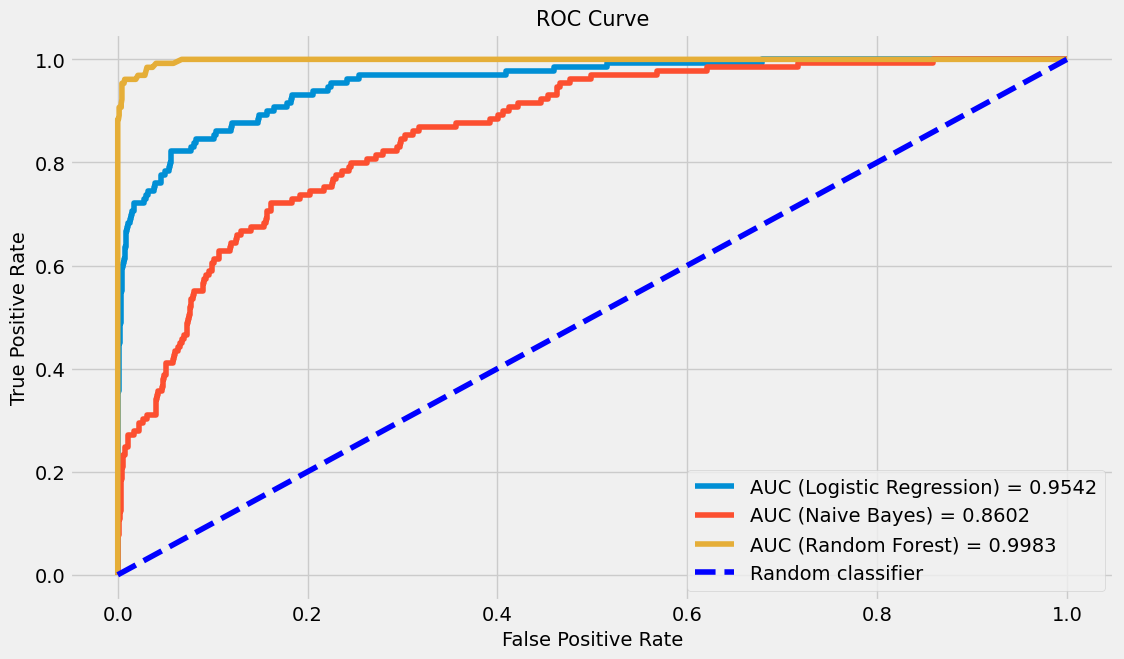

In [44]:
plt.figure(figsize=(12, 7))
plt.plot(fpr_lgb, tpr_lgb, label=f'AUC (Logistic Regression) = {auc_score_lgb:.4}')
plt.plot(fpr_nb, tpr_nb, label=f'AUC (Naive Bayes) = {auc_score_nb:.4f}')
plt.plot(fpr_rf, tpr_rf, label=f'AUC (Random Forest) = {auc_score_rf:.4f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--',label="Random classifier")
plt.title('ROC Curve', size=15)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.grid(True)
plt.legend();

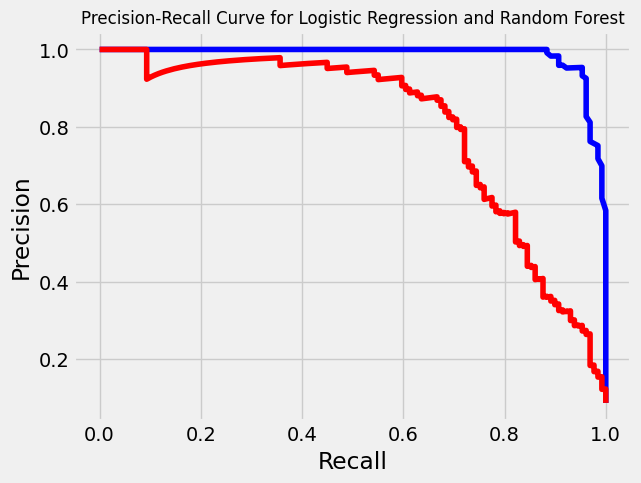

In [144]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, lgb_pred_prob)
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, rf_pred_prob)
plt.plot(recall_rf, precision_rf, color='b')
plt.plot(recall, precision, color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression and Random Forest',fontsize=12)
plt.show()

In [168]:
index_90_precision = precision_rf[precision_rf >= 0.45].argmax()
threshold_90 = thresholds_rf[index_90_precision]
threshold_90

0.54

In [169]:
precision_score(y_test,(rf_pred_prob >= threshold_90))

0.9831932773109243

In [170]:
recall_score(y_test,(rf_pred_prob >= threshold_90))

0.9069767441860465